# Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
%run "bn_utils.ipynb"

In [2]:
IN_PATH = ".\inputs"
OUT_PATH = ".\outputs"

# Exact Inference (Don't change this cell)

In [3]:
def exact_inference(query, evidence, cpts, graph):
    new_cpts = []
    parents = graph['parents_nodes']
    for i, cpt in enumerate(cpts):
        tb = []
        for row in cpt:
            if (i in evidence) and evidence[i] != row[i]:
                continue
            flag = True
            for j in parents[i]:
                if evidence.get(j) and row[j] != evidence[j]:
                    flag = False
            if flag:
                tb.append(row)
        new_cpts.append(tb)
    return variable_elimination(evidence, query, new_cpts)

# Loading Model
You should read the bayesian network from the *path* and output:
1. conditional probability tables (CPTs) [list of list of dictionary]
    - each member (cpt) is a list (the list at index *i* is cpt of vertex *i* )
    - each member of cpt is a dictionary:
        - the dictionary contains *|parents(v)| + 2* keys. (the value of parents of *v*, the value of *v* and *'prob'*)
        - e.g:
            *{
                V<sub>1</sub>: True,
                V<sub>2</sub>: False,
                ...
                V<sub>v</sub>: True,
                'prob': 0.66
            }*
<br/><br/>
2. graph (bayesian network) [dictionary of list of list]
    - the keys are *'parents_nodes'* and *'children_nodes'*
    - the value of each key is a list of list; the element at index *i* is the parents/children of vertex *i*
<br/><br/>
3. V (the number of variables/vertexes) [integer]

In [4]:
def load_model(path):
    file = open(path, 'r')
    cpt_count = int(file.readline())
    index = {
        "BU": 0, "RL": 1, "ES": 2, "FNP": 3, "PRS": 4,
        "CST": 5, "NFF": 6, "DEP": 7, "INS": 8, "SIL": 9,
        "PS": 10, "SU": 11
    }
    graph = {}
    graph["parents_nodes"] = [[] for _ in range(cpt_count)]
    graph["children_nodes"] = [[] for _ in range(cpt_count)]
    cpts = []
    # Load CPTs and build the dependency graph
    for cpt in range (cpt_count):
        elements = []
        cpt_name = file.readline().strip()
        parents = file.readline().split()
        node = parents[0].isalpha() # if it is alphabet, then it is parents list
        if node: 
            for p in parents:
                graph["parents_nodes"][index[cpt_name]].append(index[p])
                graph["children_nodes"][index[p]].append(index[cpt_name])

            for j in range(2 ** len(parents)): # 2^n elements
                probab = [float(x) for x in file.readline().split()] # read the probabilities
                true_cpt = {index[cpt_name] : True}
                false_cpt = {index[cpt_name] : False}
                for k in range(len(parents)):
                    true_cpt[index[parents[k]]] = bool(probab[k])
                    false_cpt[index[parents[k]]] = bool(probab[k])
                true_cpt["Prob"] = probab[-1]
                false_cpt["Prob"] = 1 - probab[-1]
                elements.append(true_cpt)
                elements.append(false_cpt)
            
        else: # if it is not alphabet, then it means that it is not the parents list
            prob = float(parents[0])
            elements.append({index[cpt_name] : True, "Prob" : prob})
            elements.append({index[cpt_name] : False, "Prob" : 1 - prob})
            
        cpts.append(elements)
    file.close()
    return cpts, graph, cpt_count, index





# Approximate Inference

### Prior Sampling

You should implement Prior Sampling.

1. First, sort the vertices topologically (We have done this for you; you just need to call the *topological_sort* function)

2. Sample each vertex in topological order
    - You can use np.random.random() function to generate a random number between 0 and 1
        - To propose, the *sample_vertex* function which is defined in *bn_utils* file, can be useful
<br/><br/>

3. Take enough samples from the whole bayes net, say 10000

4. Calculate the approximate probability of the query respecting to the evidence.
    - Calculate # of samples that are consistent with the evidence
    - Calculate # of samples that the query and the evidence occurred at the same time
    - The conditional probability is obtained by dividing the first item by the second

>Notice how this wouldn't work when we don't have samples that are consistent with evidence.
<br/><br/>

**Feel free to use each function in the *bn_utils* file whenever you need**

In [5]:
def prior_sample(query, evidence, cpts, graph, n):
    sorted_v = topological_sort(graph)
    evidence_consist_sum = 0
    query_consist_sum = 0
    generated_samples = []
    for s in range(10_000):
        generated_samp = {}
        for vertex in sorted_v:
            generated_samp[vertex] = True
            generated_samp[vertex] = sample_vertex(vertex, generated_samp, cpts)
        generated_samples.append(generated_samp)
    for sample in generated_samples:
        is_consistent_q = all(query[q] == sample[q] for q in query)
        is_consistent_e = all(evidence[e] == sample[e] for e in evidence)
        
        if is_consistent_e == True:
            evidence_consist_sum += 1

        if is_consistent_e == True:
            if is_consistent_q == True:
                query_consist_sum += 1
                
    return query_consist_sum / evidence_consist_sum
        



### Rejection Sampling

This is almost identical to Prior Sampling except that we reject samples that are inconsistent with the evidence.

1. First, sort the vertices topologically (Done for you! you just need to call the *topological_sort* function)

2. Sample each vertex in topological order
    - You can use np.random.random() function to generate a random number between 0 and 1
        - To propose, the *sample_vertex* function which is defined in *bn_utils* file, can be useful
    - Do not continue sampling the whole bayes net if you encounter a sampled vertex which is not consistent with the evidence; This can be more efficient in the context of time and resource.
<br/><br/>
3. Take enough samples from the whole bayes net, say 10000

4. Calculate the approximate probability of the query respecting to the evidence.
    - Calculate # of samples that the query and the evidence occurred at the same time
    - The conditional probability is obtained by dividing the above value by the total unrejected samples (notice that here all samples are consistent with the evidence because inconsistent sample were rejected)

>Notice how this still can be resource and time consuming when you go down into a deep bayesian net and reject a whole sample just because of one inconsistent vertex
<br/><br/>

**Feel free to use each function in the *bn_utils* file whenever you need**

In [6]:
def rejection_sample(query, evidence, cpts, graph, n):
    sorted_v = topological_sort(graph)
    evidence_consist_sum = 0
    query_consist_sum = 0
    s_ind = 0
    generated_samples = []

    while s_ind < 10_000:
        generated_sample = {v: -1 for v in sorted_v}
        is_sample_consistent = True

        for vertex in sorted_v:
            generated_sample[vertex] = True
            generated_sample[vertex] = sample_vertex(vertex, generated_sample, cpts)
            if vertex in evidence and evidence[vertex] != generated_sample[vertex]:
                is_sample_consistent = False  # Reject the sample
                break

        if is_sample_consistent:
            s_ind += 1
            generated_samples.append(generated_sample)

    for sample in generated_samples:
        is_consistent_q = all(query[q] == sample[q] for q in query)
        is_consistent_e = all(evidence[e] == sample[e] for e in evidence)
        if is_consistent_e:
            evidence_consist_sum += 1
            if is_consistent_q:
                query_consist_sum += 1
    if evidence_consist_sum > 0:
        return query_consist_sum / evidence_consist_sum
    else: 
        return 0

### Likelihood Sampling

To overcome the problem of rejected samples, we can force the samples to be consistent with the evidence without even sampling the vertices that appear in the evidence.

1. First, sort the vertices topologically (Done for you! you just need to call the *topological_sort* function)

2. Sample each vertex in topological order
    - If the vertex appears in the evidence, just append the probability that the variable has the same value as in the evidence, to a list of weights
    - Otherwise, sample the vertex as usual
    - On sampling the whole bayes net, you should calculate the weight of that sample by multiplying the weights in the list of weights
    - Add the sample's weight to a list, say sample_weights
<br/><br/>

3. Take enough samples from the whole bayes net, say 10000

4. Calculate the approximate probability of the query respecting to the evidence.
    - Calculate sum of samples' weights that the query and the evidence occurred at the same time
    - The conditional probability is obtained by dividing the above value by the sum of all samples' weights

>Notice that in this approach, when sampling vertices, we do not consider the evidence variables that are deeper in the bayes net
<br/><br/>

**Feel free to use each function in the *bn_utils* file whenever you need**

In [7]:
def likelihood_sample(query, evidence, cpts, graph, n):
    sorted_v = topological_sort(graph)
    evidence_consist_sum = 0
    query_consist_sum = 0 
    generated_samples = []
    for _ in range(10_000):
        generated_sample = {}
        weight = 1.0
        generated_sample = {v: -1 for v in sorted_v}
        for vertex in sorted_v:
            if vertex in evidence:
                generated_sample[vertex] = evidence[vertex]
                weight *= find_row(cpts[vertex], generated_sample)
            else:
                generated_sample[vertex] = True
                generated_sample[vertex] = sample_vertex(vertex, generated_sample, cpts)
        
        generated_samples.append((generated_sample, weight))

    for sample in generated_samples:
        is_consistent_q = all(query[q] == sample[0][q] for q in query)
        evidence_consist_sum += sample[1]
        if is_consistent_q:
            query_consist_sum += sample[1]
    
    return query_consist_sum / evidence_consist_sum

### Gibbs Sampling
Gibbs sampling is one of the Monte Carlo sampling methods which work based on random assignment.
<br/>
This algorithm is composed from 3 steps; 1.Fix evidence - 2.Initialize other variables - 3.Resampling
<br/><br/>
1. First, sort the vertices topologically (Done for you! you just need call the *topological_sort* function)
<br/><br/>
2. Fix the value of evidences
    - iterate over all vertices
    - if the vertex is evidence assign it by previous value
<br/><br/>
3. Sample each vertex in topological order
    - if the vertex doesn't appear in the evidence, sample this vertex (you can use the *sample_vertex* method for sampling)
<br/><br/>
4. Take enough samples from the whole bayes net, say 10000
<br/><br/>
5. Calculate the approximate probability of the query respecting to the evidence.
    - Calculate # of samples which are consistent with query
    - The conditional probability is obtained by dividing the above value by the all samples
<br/><br/>

**Feel free to use each function in the *bn_utils* file whenever you need**

In [8]:
def resample_vertex(node, values, cpts, graph):
    sample = values.copy()
    sample[node] = True
    prob = find_row(cpts[node], sample)
    for vertex in graph["children_nodes"][node]:
        prob *= find_row(cpts[vertex], sample)
    sample[node] = False
    a = find_row(cpts[node], sample)
    for vertex in graph["children_nodes"][node]:
        a *= find_row(cpts[vertex], sample)
    a += prob
    prob /= a
    if np.random.random() < prob:
        sample[node] = True
    else:
        sample[node] = False
    return sample

def gibbs_sample(query, evidence, cpts, graph, n):
    sorted_v = topological_sort(graph)
    evidence_query_sum = 0 
    generated_samples = []
    for _ in range(10_000):
        generated_sample = {vertex: -1 for vertex in sorted_v}
        for vertex in sorted_v:
            if vertex in evidence:
                generated_sample[vertex] = evidence[vertex]
            else:
                generated_sample[vertex] = True
                generated_sample[vertex] = sample_vertex(vertex, generated_sample, cpts)     
        for vertex in sorted_v:
            if vertex not in evidence:
                generated_sample = resample_vertex(vertex, generated_sample, cpts, graph)
        generated_samples.append(generated_sample)

    for s in generated_samples:
        is_consistent_q = all(query[q] == s[q] for q in query)
        if is_consistent_q:
            evidence_query_sum += 1
    
    return evidence_query_sum / len(generated_samples)


## Reading Queries
You should read the queries from the *path* and output:
1. queries [list of dictionary]
    - the *keys* are the query vertexes and the *values* are the value(*True/False*) of vertexes
    - e.g: {V<sub>1</sub>:True, V<sub>2</sub>: True, ..., V<sub>m</sub>: False}
<br/><br/>
2. evidences [list of dictionary]
    - the *keys* are the evidence vertexes and the *values* are the value(*True/False*) of vertexes
    - e.g: {V<sub>1</sub>:True, V<sub>2</sub>: True, ..., V<sub>m</sub>: False}
<br/><br/>
>Note that the evidence at index ***i*** in *evidences* corresponds the the query at index ***i*** in *queries*

In [9]:
def read_queries(path):
    index = {
        "BU": 0, "RL": 1, "ES": 2, "FNP": 3, "PRS": 4,
        "CST": 5, "NFF": 6, "DEP": 7, "INS": 8, "SIL": 9,
        "PS": 10, "SU": 11
    }
    file = open(path, "r")
    inputs = eval(file.read())
    queries = []
    evidences = []
    for i in inputs:
        query = i[0]
        evidence = i[1]
        new_query = {}
        new_evidence = {}
        for q in query.keys():
            new_query[index[q]] = bool(query[q])
        for e in evidence.keys():
            new_evidence[index[e]] = bool(evidence[e])
        queries.append(new_query)
        evidences.append(new_evidence)
    
    return (queries, evidences)


## Execution

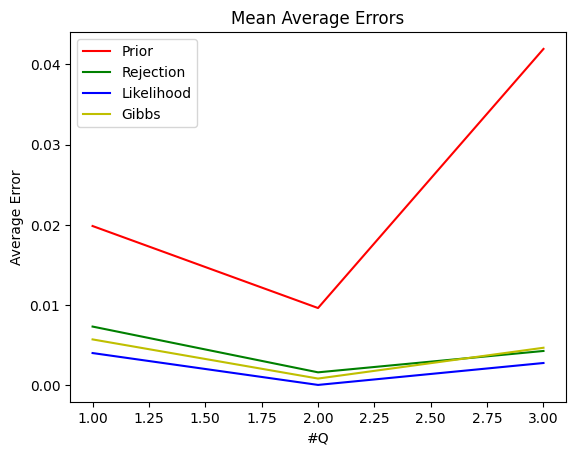

In [10]:
cpts, graph, V, indecis = load_model(IN_PATH + "\model.txt")
queries, evidences = read_queries(IN_PATH + "\queries.txt")

exact_vals = []
prior_ae_vals = []
rejection_ae_vals = []
likelihood_ae_vals = []
gibbs_ae_vals = []

for i in range(len(queries)):
    exact_val = exact_inference(queries[i], evidences[i], cpts, graph)
    prior = prior_sample(queries[i], evidences[i], cpts, graph, V)
    rejection = rejection_sample(queries[i], evidences[i], cpts, graph, V)
    likelihood = likelihood_sample(queries[i], evidences[i], cpts, graph, V)
    gibbs = gibbs_sample(queries[i], evidences[i], cpts, graph, V)
    exact_vals.append(exact_val)
    prior_ae_vals.append(np.abs(prior - exact_val))
    rejection_ae_vals.append(np.abs(rejection - exact_val))
    likelihood_ae_vals.append(np.abs(likelihood - exact_val))
    gibbs_ae_vals.append(np.abs(gibbs - exact_val))


draw_plot(prior_ae_vals, rejection_ae_vals, likelihood_ae_vals, gibbs_ae_vals, "Mean Average Errors")
with open(OUT_PATH + "\\output.txt", mode="w") as file:
    outputs= f"outputs:\nExact Values:{exact_vals}\nPrior Errors: {prior_ae_vals}\nRejection Errors: {rejection_ae_vals}\nLikelihood Errors: {likelihood_ae_vals}\nGibbs Errors: {gibbs_ae_vals}"
    file.write(outputs)
